# PulsePortraiture Example:
## --- Fit a spline model describing profile evolution and generate TOAs ---

#### PSRCHIVE-style metafile listing data archives to use

In [1]:
metafile = 'example.meta'

### (0) Make fake data, if needed
#### This uses a Gaussian-component description for making fake data, but any data will do
##### This section can be skipped if you have some data to use, just set the metafile variable above to the right name

In [2]:
from pplib import DataPortrait, make_fake_pulsar, make_constant_portrait  # pplib.py contains many common features
import psrchive as pr
import numpy as np

#### Input profile model and ephemeris used to make fake pulsar data


In [3]:
# ppgauss.py-style model file for fake pulsar, constructed using Gaussian components
modelfile = 'example.gmodel'
# The use of this ephemeris is limited (no binary params) / not so important here (only spin period really matters)
ephemeris = 'example.par'

#### Set parameters for fake data

In [4]:
# These files will be homogenous, even though they don't need to be
nfiles = 5       # Number of datafiles/epochs
MJD0 = 57202.00  # Start day [MJD]
days = 20.0      # Days between epochs
nsub = 10        # Number of subintegrations
npol = 1         # Number of polarization (can be 4, but will only use total intensity)
nchan = 64       # Number of frequency channels
nbin = 512       # Number of phase bins
nu0 = 1500.0     # Center of the band [MHz]
bw = 800.0       # Bandwidth [MHz]
tsub = 60.0      # Length of subintegration [s]
noise_std = 1.5  # Noise level of the band, per subintegration [flux units]
dDM_mean = 3e-4  # Add in random dispersion measure offsets with this mean value
dDM_std = 2e-4   # Add in random dispersion measure offsets with this std
dDMs = np.random.normal(dDM_mean, dDM_std, nfiles)
#dDMs = np.zeros(nfiles) # Uncomment this line and comment previous line for no injected dDMs
scint = True     # Add random scintillation; scattering parameters will be read from the modelfile
weights = np.ones([nsub, nchan]) # Change if you want to have an "RFI" mask
                                 # e.g., band edges zapped:
                                 # weights[:,:10] = weights[:,-10:] = 0.0
                                 # e.g. first and last subints zapped:
                                 # weights[0] = weights[-1] = 0.0

#### Generate fake data

In [5]:
# Uses old, clunky function, but it works
for ifile in range(nfiles):
    start_MJD = pr.MJD(MJD0 + ifile*days)
    make_fake_pulsar(modelfile, ephemeris, outfile='example-%d.fits'%(ifile+1),
            nsub=nsub, npol=npol, nchan=nchan, nbin=nbin, nu0=nu0, bw=bw,
            tsub=tsub, phase=0.0, dDM=dDMs[ifile], start_MJD=start_MJD,
            weights=weights, noise_stds=noise_std, scales=1.0,
            dedispersed=False, scint=scint, state='Stokes', telescope='GBT',
            quiet=True)

In [6]:
# Use psredit to set some header info in the fake data archives
! psredit -q -m -c rcvr:name='fake_rx' -c be:name='fake_be' example-*.fits


Updating example-1.fits ... done

Updating example-2.fits ... done

Updating example-3.fits ... done

Updating example-4.fits ... done

Updating example-5.fits ... done


In [7]:
# Create metafile
! ls example-[0-9]*.fits > example.meta

### (1) Make an average portrait using ppalign.py
#### This aligns and averages the data based on a constant phase offset plus a frequency**-2 rotation
##### The following is equivalent to the command-line version:
##### ppalign.py -M example.meta -I example-1.fits -T -C 15.0 -o example.port --niter 1

In [8]:
import ppalign as ppa  # Import ppalign.py

#### Align and average archives

In [9]:
# First make a dummy archive filled with the average profile from one fake data archive to use as the initial alignment
dp = DataPortrait('example-1.fits', quiet=True)  # load first fake data archive as a 'DataPortait' class instance
make_constant_portrait("example-1.fits", "example-init.fits", profile=dp.prof, DM=0.0,
                    dmc=False, weights=None, quiet=False)


Unloaded example-init.fits.



In [10]:
# The following uses an average profile as an initial guess for the alignment and iterates a few times, using the
#   resulting average portrait as the starting alignment for the subsequent iteration
# A frequency-averaged profile can also be used as an initial alignment
# Another good option is to use one Gaussian component for initial alignment; from the command line (see ppalign.py -h):
#   ppalign.py -M example.meta -g 0.1 -T -C 15.0 -o example.port --niter 3
# The SNR_cutoff is optional, but useful when filtering out non-detections
outfile = 'example.port'  # output average portrait name
ppa.align_archives(metafile=metafile, initial_guess='example-init.fits', fit_dm=True,
                   tscrunch=True, pscrunch=True, SNR_cutoff=15.0, outfile=outfile, niter=3, quiet=True)

Doing iteration 1...
Doing iteration 2...
Doing iteration 3...


### Make a model of profile evolution using ppspline.py
#### This uses Principal Component Analysis to decompose the average portrait into significant eigenprofiles and fits a spline to the projection of the data onto the basis; see Pennucci (2019).
##### The following is equivalent to the command-line version:
##### ppspline.py -d example.port  -o example-fit.spl -N prof -s -n 3

In [11]:
import ppspline as pps  # Import ppspline.py

#### Load data and normalize

In [12]:
datafile = 'example.port'  # average data portrait to model
# Initiate class instance
dp = pps.DataPortrait(datafile)
dp.normalize_portrait('prof')  # This normalization is based on the mean profile and seems to work well


Reading data from example.port on source J1234-5678...
	P [ms]             = 2.893
        DM [cm**-3 pc]     = 0.000000
        center freq. [MHz] = 1500.0000
        bandwidth [MHz]    = 800.0
        # bins in prof     = 512
        # channels         = 64
        # chan (mean)      = 64
        # subints          = 1
        # unzapped subint  = 1
        pol'n state        = Intensity



#### Have a look at the data you will model

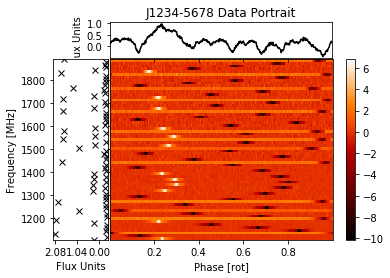

In [13]:
dp.show_data_portrait()

#### Set some modeling parameters

In [14]:
# NB: normally we wouldn't set max_ncomp, but it is set here to speed things up for the fake data exercise
max_ncomp = 3  # use None [default] if analyzing arbitrary data with an unknown number of significant eigenprofiles
# NB: in very high S/N pulsars, the automatic smoothing algorithm may be insufficient and more finessing is necessary
smooth = True  # [default] smoothing is recommended, but it is not the command-line default (hence the -s option above)
snr_cutoff = 150.0  # [default] the S/N cut off for determining significant eigenprofiles
rchi2_tol = 0.1  # [default] the tolerance around a red. chi2 of 1.0 to help the auto-smoothing of the mean/eigen profiles
k = 3  # [default] polynomial degree of the B-splines
sfac = 1.0  # [default] smoothing "fudge" factor, which will determing the smoothness of the interpolating spline
max_nbreak = None  # [default] the maximum number of spline breakpoints; this may be used instead of sfac

#### Make the model

In [15]:
# This can be as simple as dp.make_spline_model(); arguments shown for clarity
dp.make_spline_model(max_ncomp=max_ncomp, smooth=smooth, snr_cutoff=snr_cutoff, rchi2_tol=rchi2_tol, k=k, sfac=sfac,
                     max_nbreak=max_nbreak, model_name=None, quiet=False)

Performing principal component analysis on data with 512 dimensions and 64 measurements...
B-spline interpolation model example.port.spl uses 3 basis profile components and 58 breakpoints (60 B-splines with k=3).


/home/bmeyers/.local/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:296: RuntimeWarning: The spline has a residual sum of squares fp such that abs(fp-s)/s<=0.001	k=3 n=64 m=64 fp=0.073119 s=0.073123
  (k, len(t), m, fp, s)))


#### Have a look at the mean profile and eigenprofiles


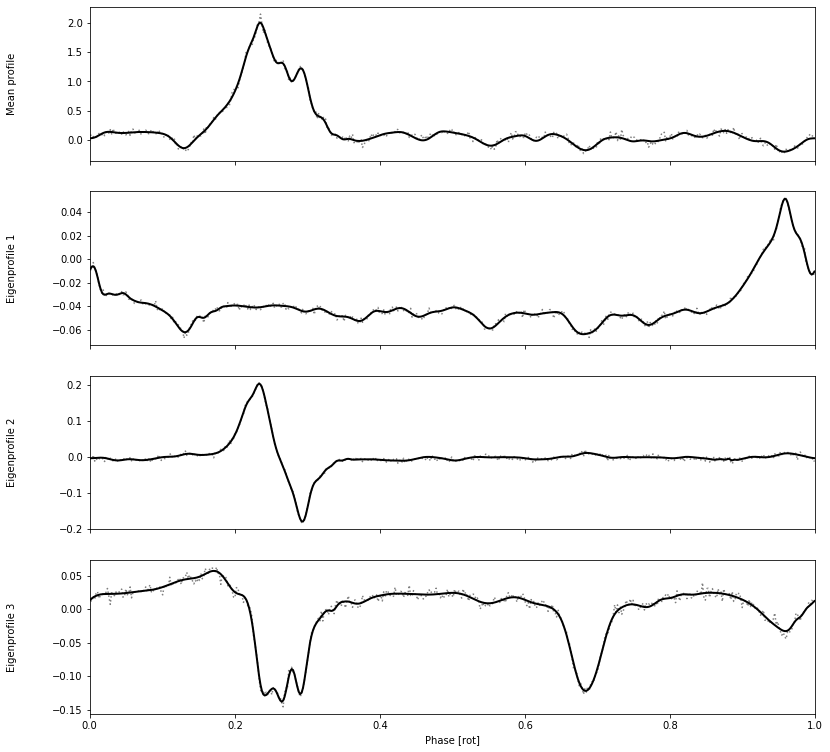

In [16]:
dp.show_eigenprofiles()

#### Have a look at the spline curve model of profile evolution

In [ ]:
dp.show_spline_curve_projections()

#### Write the model to file

In [ ]:
fitted_modelfile = 'example-fit.spl'  # output model file
dp.write_model(fitted_modelfile, quiet=False)

### Generate "wideband" TOAs with DM measurements using pptoas.py
#### This uses a Fourier-domain phase-gradient algorithm like Taylor (1992); see Pennucci, Demorest, Ransom (2014).
##### The following is equivalent to the command-line version:
##### pptoas.py -d example.meta -m example-fit.spl -o example.tim

In [ ]:
import pptoas as ppt  # Import pptoas.py
from pplib import write_TOAs  # and the function to write TOAs from pplib.py

#### Initiate class instance and get TOAs

In [ ]:
# One could also use a .gmodel Gaussian model file or a smoothed average of the data as an input model
gt = ppt.GetTOAs(metafile, fitted_modelfile)
gt.get_TOAs()  # The default will output the TOAs at a reference frequency such that they have zero covariance w/ DM

#### Have a look at how one subintegration was fit by the model

In [ ]:
gt.show_fit(datafile=gt.datafiles[0], isub=0)  # datafile=None will just select the first datafile from the metafile

#### Write TOAs

In [ ]:
timfile = 'example.tim'
# There is an optional SNR_cutoff and way to append to an existing timfile
write_TOAs(gt.TOA_list, SNR_cutoff=0.0, outfile=timfile, append=False)

#### Note on measuring the TOA and DM together with scattering timescale and index; see Pennucci et al. (forthcoming) --
#####  If you have a profile evolution model of the unscattered portrait (Gaussian-component based, or otherwise), fitting scattering is easy:
##### pptoas.py -d example.meta -m example.gmodel -o example.tim --fit_scat
#####  Try ppgauss.py for one way to estimate an unscattered portrait model.

### Run Tempo
#### This is just to demonstrate the simplest possible timing
##### The following is equivalent to the command-line version:
##### tempo -G -f example.par example.tim

In [ ]:
import tempo_utils as tu  # Import tempo_utils to do the analysis
import matplotlib.pyplot as plt  # and pyplot for simple plots

#### Input files

In [ ]:
parfile = 'example.par'
timfile = 'example.tim'

#### Add MODE/FORMAT lines to .tim file if necessary

In [ ]:
# Comment these out if FORMAT 1 and MODE 1 are already in place
! sed -i '1s/^/FORMAT 1\n/' example.tim
! sed -i '1s/^/MODE 1\n/' example.tim

#### Add DMDATA 1 if necessary

In [ ]:
# DMDATA 1 is necessary for tempo to make use of the DM measurements (--pp_dm on the TOA lines)
parfile_keys = tu.parfile(parfile).keys
if 'DMDATA' not in parfile_keys:
    ! echo 'DMDATA 1' >> example.par

#### Read TOAs and run tempo with GLS

In [ ]:
toas = tu.read_toa_file(timfile)
tu.run_tempo(toas, parfile, gls=True)  # GLS is necessary for tempo to make use of the DM measurements

#### Have a look at the residuals

In [ ]:
plt.errorbar(toas.get_mjd(), toas.get_resids(), toas.get_resid_err(), fmt='kx')
plt.xlabel('MJD')
plt.ylabel('Residual [us]')

#### Have a look at the DM measurements

In [ ]:
plt.errorbar(toas.get_mjd(), map(float, toas.get_flag('pp_dm')), map(float, toas.get_flag('pp_dme')), fmt='kx')
plt.xlabel('MJD')
plt.ylabel(r'DM [cm$^{-3}$ pc]')